# Setup

In [16]:
import os
import sys

sys.path.append(os.path.abspath("../.."))

In [17]:
from pathlib import Path
import pandas as pd
import numpy as np
import torch

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from src.experiment.sets.metric_sets import create_full_multilabel_metrics, create_full_multiclass_metrics, create_full_binary_metrics

from src.experiment.helpers.variables import report_output_root_dir

from src.experiment.helpers.task_type import TaskType
from src.experiment.metric_processing.metric_calc import update_metrics_using_probabilities, compute_metrics, create_metric_dictionary
from src.experiment.metric_processing.metric_display import print_metric_dictionary
from src.experiment.metric_processing.metric_reports import write_results_report_to_new_file, experiment_info, fold_info

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [18]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

In [19]:
from src.experiment.helpers.variables import dataset_root_dir
dataset_root_dir

WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets')

In [20]:
output_dir_base = report_output_root_dir
output_dir_base

WindowsPath('C:/VisualStudioRepositories/MUSIC_DATA/metric_analysis/output')

# Settings

In [21]:
REPETITIONS = 5

In [22]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

def get_preprocessor(X):
    X_df = pd.DataFrame(X)

    binary_cols = [col for col in X_df.columns if set(X_df[col].dropna().unique()).issubset({0, 1})]
    categorical_cols = [col for col in X_df.select_dtypes(include='object') if col not in binary_cols]
    numeric_cols = [col for col in X_df.select_dtypes(exclude='object') if col not in binary_cols]

    preprocessor = ColumnTransformer(
        transformers=[
            ('binary', FunctionTransformer(validate=False), binary_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
            ('num', StandardScaler(), numeric_cols),
        ],
        remainder='drop'
    )
    
    print(f"Preprocessor created with {len(binary_cols)} binary, {len(categorical_cols)} categorical, and {len(numeric_cols)} numeric columns.")
    return preprocessor


In [23]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

binary_multiclass_models = {
    'logistic_regression': lambda X: Pipeline([
        ('preprocess', get_preprocessor(X)),
        ('clf', LogisticRegression(max_iter=1000, random_state=42, class_weight=None, n_jobs=-1))
    ]),
     'decision_tree': lambda X: Pipeline([
         ('preprocess', get_preprocessor(X)),
         ('clf', DecisionTreeClassifier(random_state=42, class_weight=None))
     ]),
     'random_forest': lambda X: Pipeline([
         ('preprocess', get_preprocessor(X)),
         ('clf', RandomForestClassifier(random_state=42, class_weight=None, n_jobs=-1))
     ]),
    'knn': lambda X: Pipeline([
         ('preprocess', get_preprocessor(X)),
         ('clf', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
     ]),
}

In [8]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

multilabel_models = {
    # 'logistic_regression': lambda X: Pipeline([
    #     ('preprocess', get_preprocessor(X)),
    #     ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42, class_weight=None, n_jobs=-1)))
    # ]),
    #  'decision_tree': lambda X: Pipeline([
    #      ('preprocess', get_preprocessor(X)),
    #      ('clf', MultiOutputClassifier(DecisionTreeClassifier(random_state=42, class_weight=None)))
    #  ]),
    #  'random_forest': lambda X: Pipeline([
    #      ('preprocess', get_preprocessor(X)),
    #      ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=42, class_weight=None, n_jobs=-1)))
    #  ]),
    # 'knn': lambda X: Pipeline([
    #      ('preprocess', get_preprocessor(X)),
    #      ('clf', MultiOutputClassifier(KNeighborsClassifier(n_neighbors=5, n_jobs=-1)))
    #  ]),
}

In [24]:
from src.experiment.sets.binary_balanced_datasets import binary_balanced_datasets
binary_balanced_datasets

{'fake-news_balanced': {'path': WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets/binary/fake-news_balanced'),
  'classification_type': 'binary',
  'class_balance': 'balanced',
  'dataset_name': 'fake-news_balanced'}}

In [25]:
from src.experiment.sets.binary_imbalanced_datasets import binary_imbalanced_datasets
binary_imbalanced_datasets

{'fake-news_imbalanced': {'path': WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets/binary/fake-news_imbalanced'),
  'classification_type': 'binary',
  'class_balance': 'imbalanced',
  'dataset_name': 'fake-news_imbalanced'}}

In [9]:
from src.experiment.sets.multiclass_balanced_datasets import multiclass_balanced_datasets
multiclass_balanced_datasets

{'nyt-comments-april17_balanced': {'path': WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets/multiclass/nyt-comments-april17_balanced'),
  'classification_type': 'multiclass',
  'class_balance': 'balanced',
  'dataset_name': 'nyt-comments-april17_balanced'}}

In [9]:
from src.experiment.sets.multiclass_imbalanced_datasets import multiclass_imbalanced_datasets
multiclass_imbalanced_datasets

{'nyt-comments-april17_imbalanced': {'path': WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets/multiclass/nyt-comments-april17_imbalanced'),
  'classification_type': 'multiclass',
  'class_balance': 'imbalanced',
  'dataset_name': 'nyt-comments-april17_imbalanced'}}

In [ ]:
from src.experiment.sets.multilabel_balanced_datasets import multilabel_balanced_datasets
multilabel_balanced_datasets

In [ ]:
from src.experiment.sets.multilabel_imbalanced_datasets import multilabel_imbalanced_datasets
multilabel_imbalanced_datasets

# Loop

In [26]:
from sklearn.base import clone

def cross_validation(X, y, dataset_info, class_names, mskf, metrics, output_dir, index, model, model_name, task_type):    
    for fold, (train_idx, test_idx) in enumerate(mskf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        train_dist = y_train.sum(axis=0)
        test_dist = y_test.sum(axis=0)
        train_pct = train_dist / len(y_train) * 100
        test_pct = test_dist / len(y_test) * 100
        
        fold_information = fold_info(
            train_distribution=train_dist.tolist(),
            test_distribution=test_dist.tolist(),
            train_distribution_pct=train_pct.tolist(),
            test_distribution_pct=test_pct.tolist(),
        )
        
        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
     
        probas = model_clone.predict_proba(X_test)

        if task_type == TaskType.BINARY:
            probas = probas[:, 1]
            
     
        if isinstance(probas, list):
            y_probas = np.vstack([p[:, 1] for p in probas]).T # MultiOutputClassifer
        else:
            y_probas = probas # OneVsRestClassifier
        
        
        update_metrics_using_probabilities(metrics, y_probas, y_test)
        computed_metrics = compute_metrics(metrics)
        
        output_dir_final = output_dir / f"fold_{fold}"
        output_dir_final.mkdir(parents=True, exist_ok=True)
        
        exp_info = experiment_info(
            model_name=model_name,
            classification_type=dataset_info["classification_type"],
            class_balance=dataset_info["class_balance"],
            dataset_name=dataset_info["dataset_name"],
            class_names=class_names,
            index=index,
            cv_fold=fold,
        )
        
        write_results_report_to_new_file(
            output_dir_path=output_dir_final,
            results=computed_metrics,
            fold_info=fold_information,
            experiment_info=exp_info
            )
        
        print(f"Results written to {output_dir_final} directory.\n")

In [27]:
from sklearn.model_selection import StratifiedKFold


def repeated_cross_validation(X, y, dataset_info, class_names, repetitions, output_dir, metrics, model, model_name, task_type):
    for index in range(repetitions):
        output_dir_with_index = output_dir / f"{index}"
        
        if task_type == TaskType.MULTILABEL:
            mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=index)
        else:
            mskf = StratifiedKFold(n_splits=5, shuffle=True, random_state=index)
        
        cross_validation(X, y, dataset_info, class_names, mskf, metrics, output_dir_with_index, index, model, model_name, task_type)
        

In [28]:
def perform_experiments(datasets, models, repetitions, output_dir_base, task_type):
    for _, dataset_info in datasets.items():
        X_df = pd.read_csv(dataset_info["path"] / 'X.csv')
        y_df = pd.read_csv(dataset_info["path"] / 'y.csv')

        if task_type == TaskType.MULTILABEL:
            class_names = list(y_df.columns)
            class_no = len(class_names)
        else:
            class_names = y_df.iloc[:, 0].unique().tolist()
            class_no = len(class_names)
        
        X = X_df.to_numpy()
        y = y_df.to_numpy()    
        
        if task_type != TaskType.MULTILABEL:
            y = y.ravel()
            
        
        output_dir = output_dir_base / dataset_info['classification_type'] / dataset_info['class_balance'] / dataset_info['dataset_name']
        
        if task_type == TaskType.BINARY:
            metrics = create_full_binary_metrics(device="cpu")
        elif task_type == TaskType.MULTICLASS:
            metrics = create_full_multiclass_metrics(class_no, device="cpu")
        elif task_type == TaskType.MULTILABEL:
            metrics = create_full_multilabel_metrics(class_no, device="cpu")
        
        for model_name, model_fn in models.items():
            model = model_fn(X)
            output_dir_with_model = output_dir / model_name
            repeated_cross_validation(X, y, dataset_info, class_names, repetitions, output_dir_with_model, metrics, model, model_name, task_type)
    

### Binary

In [ ]:
perform_experiments(binary_balanced_datasets, binary_multiclass_models, REPETITIONS, output_dir_base, TaskType.BINARY)

Preprocessor created with 2150 binary, 0 categorical, and 0 numeric columns.
Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\fake-news_imbalanced\logistic_regression\0\fold_0 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\fake-news_imbalanced\logistic_regression\0\fold_1 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\fake-news_imbalanced\logistic_regression\0\fold_2 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\fake-news_imbalanced\logistic_regression\0\fold_3 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\fake-news_imbalanced\logistic_regression\0\fold_4 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\fake-news_imbalance

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metric_processing\metric_display.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 6))


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\fake-news_imbalanced\logistic_regression\4\fold_0 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\fake-news_imbalanced\logistic_regression\4\fold_1 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\fake-news_imbalanced\logistic_regression\4\fold_2 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\fake-news_imbalanced\logistic_regression\4\fold_3 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\fake-news_imbalanced\logistic_regression\4\fold_4 directory.

Preprocessor created with 2150 binary, 0 categorical, and 0 numeric columns.
Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\fake-news_imbalance

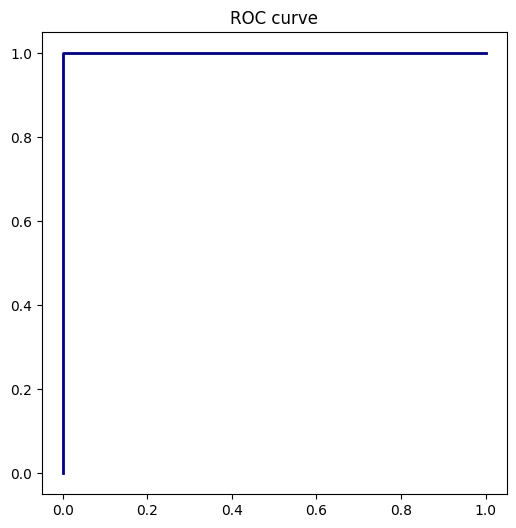

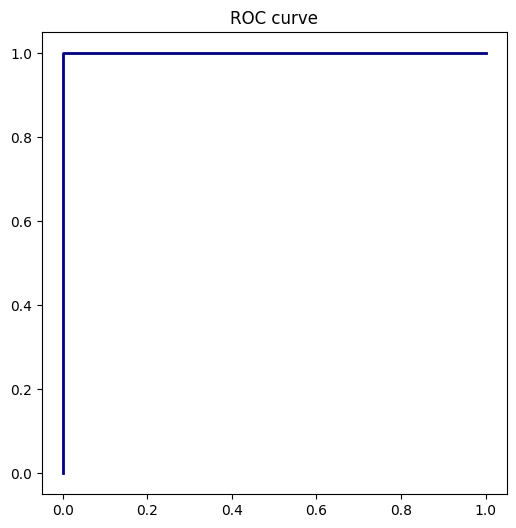

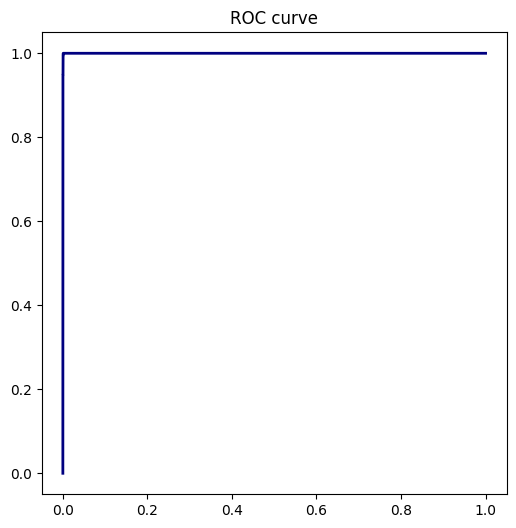

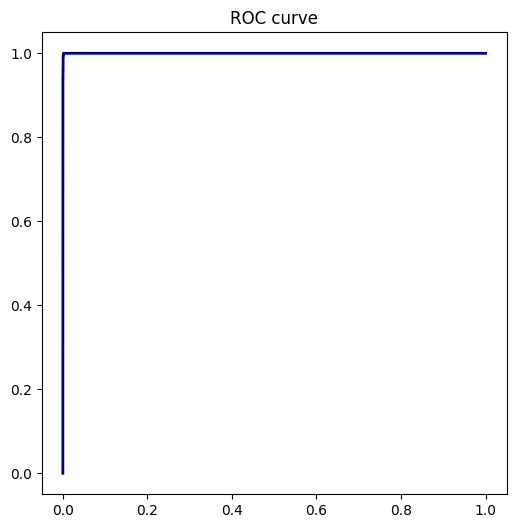

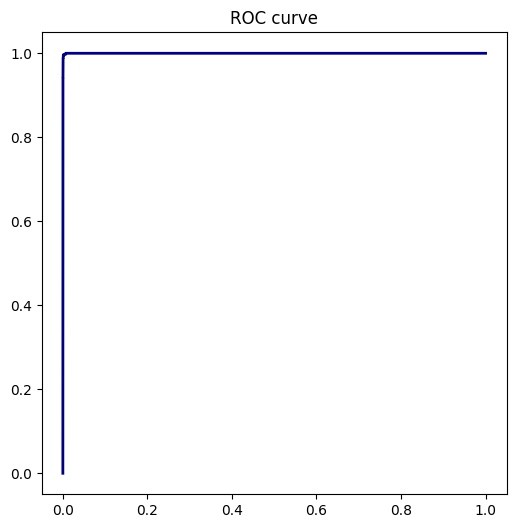

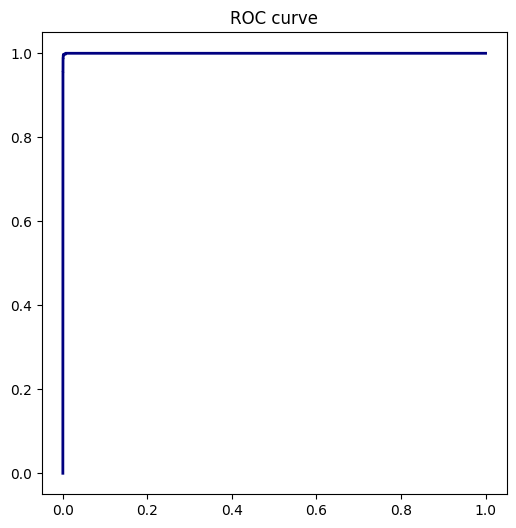

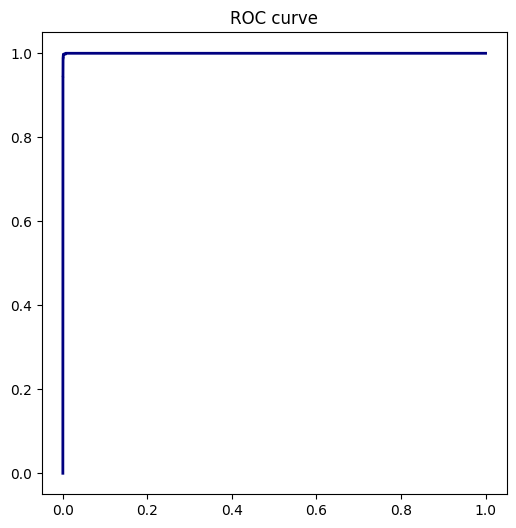

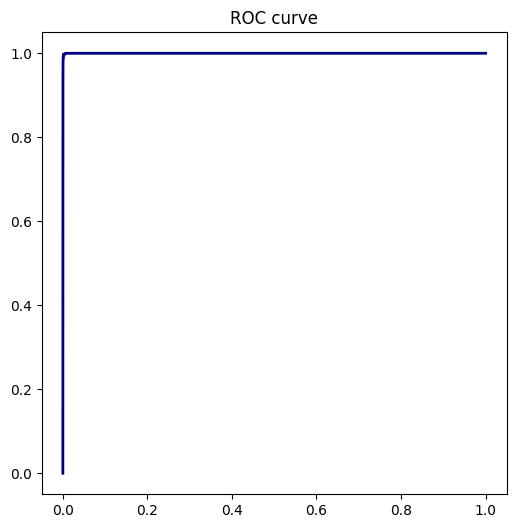

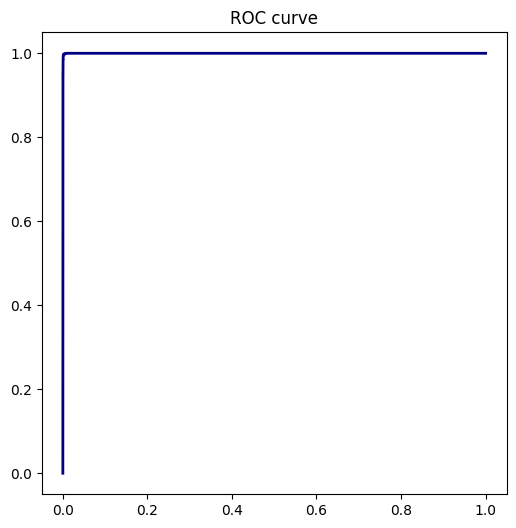

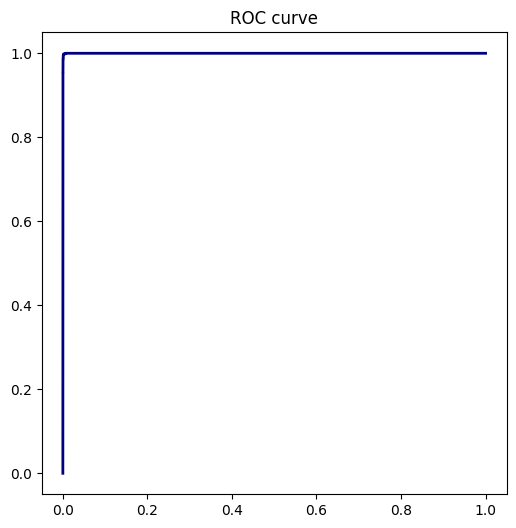

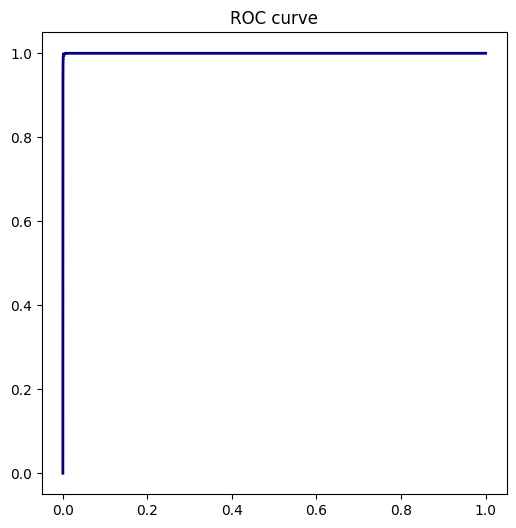

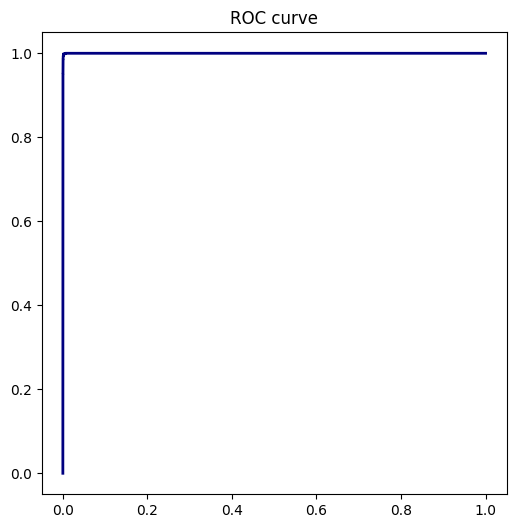

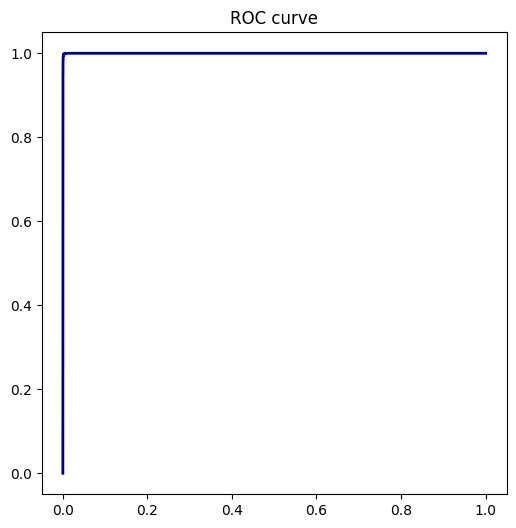

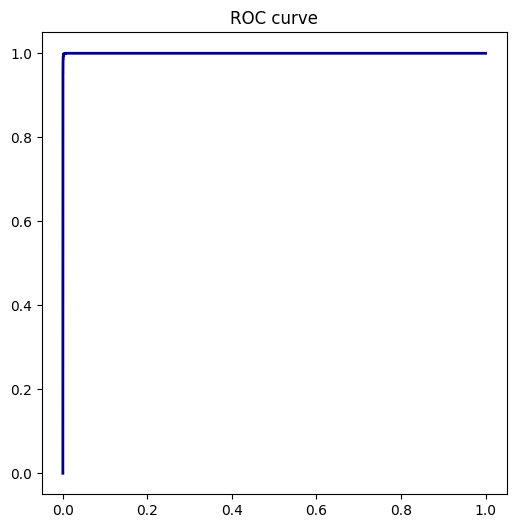

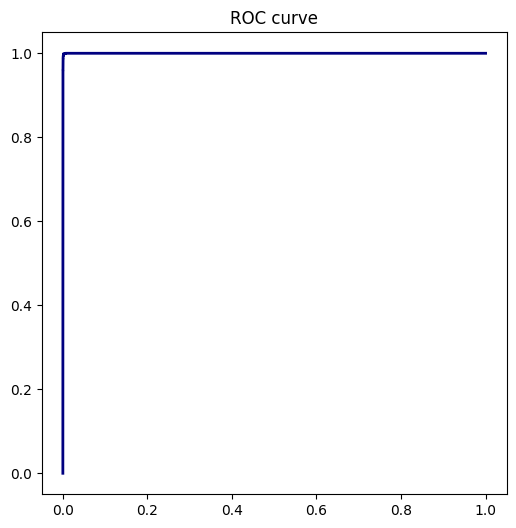

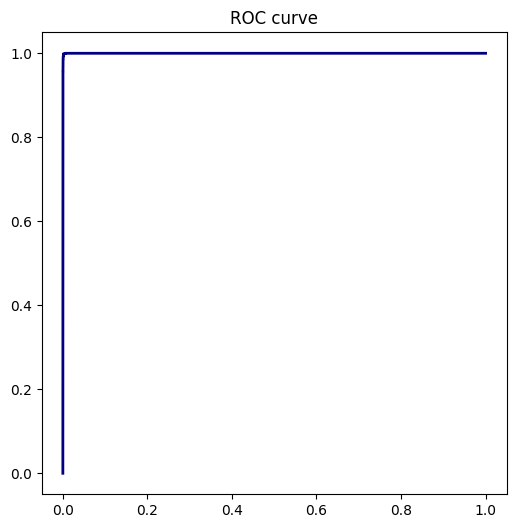

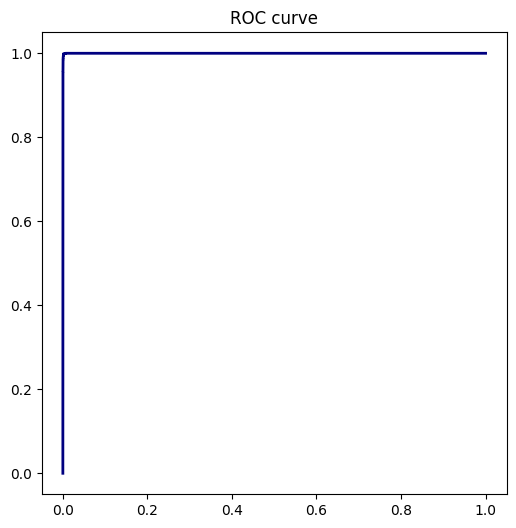

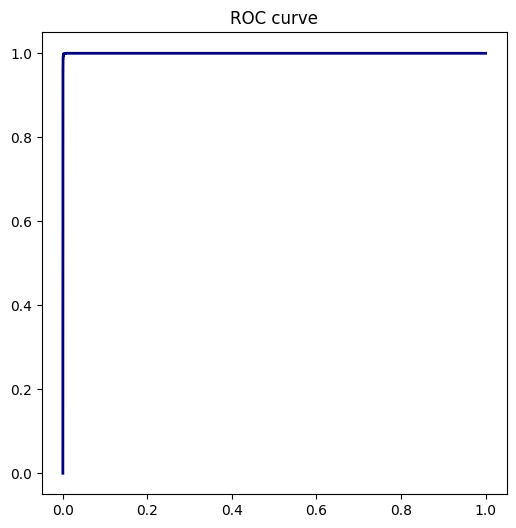

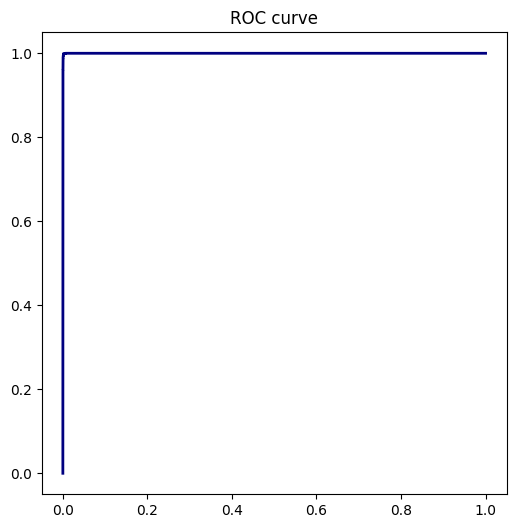

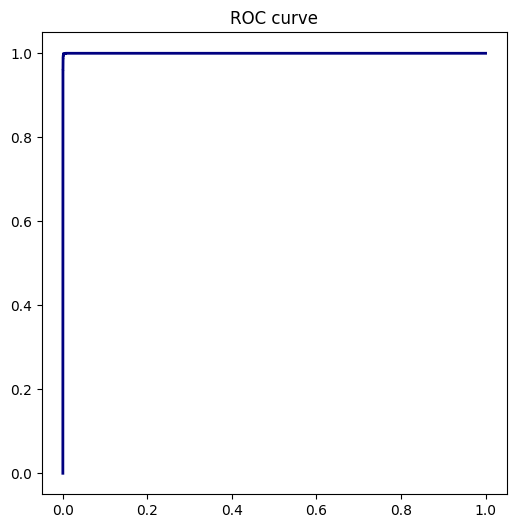

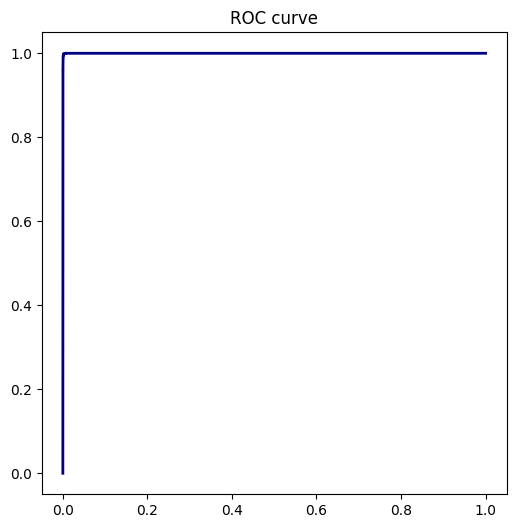

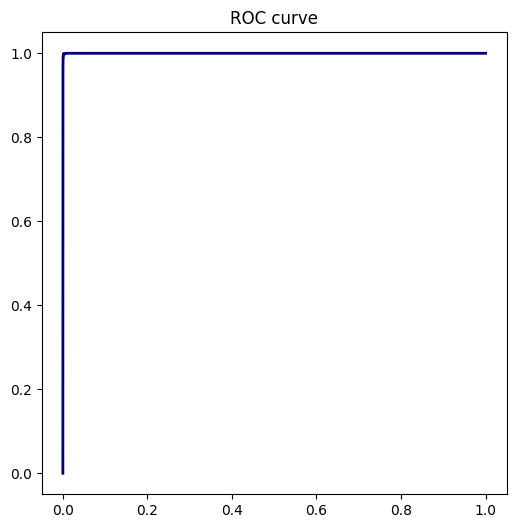

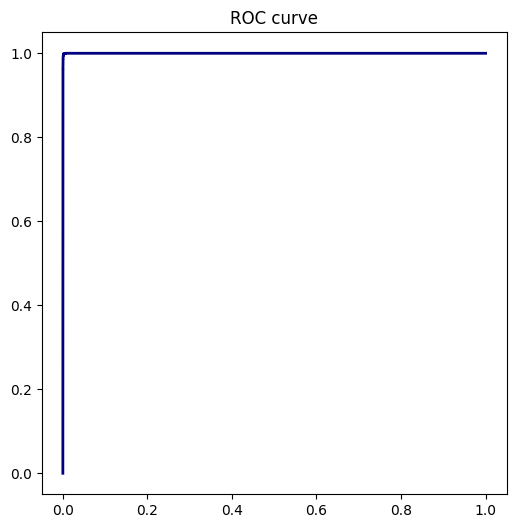

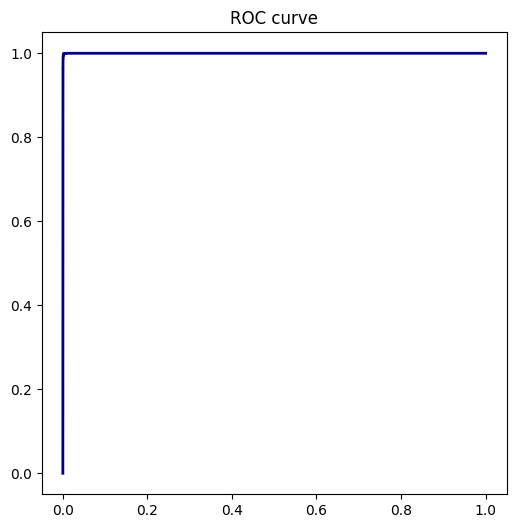

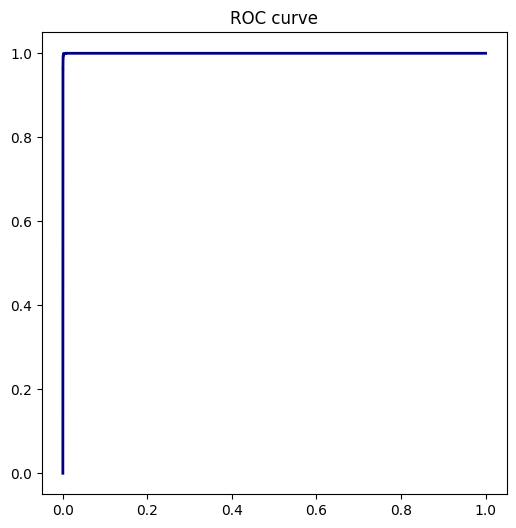

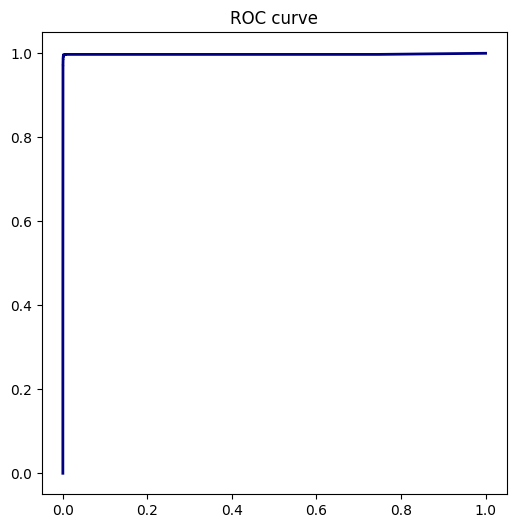

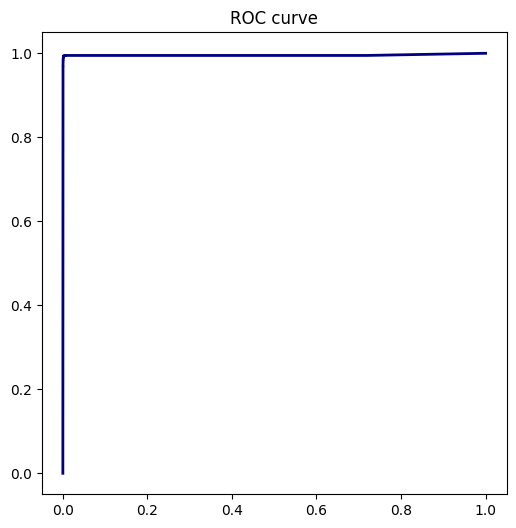

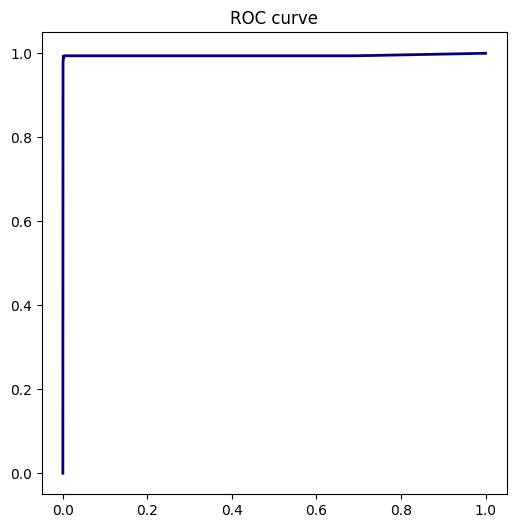

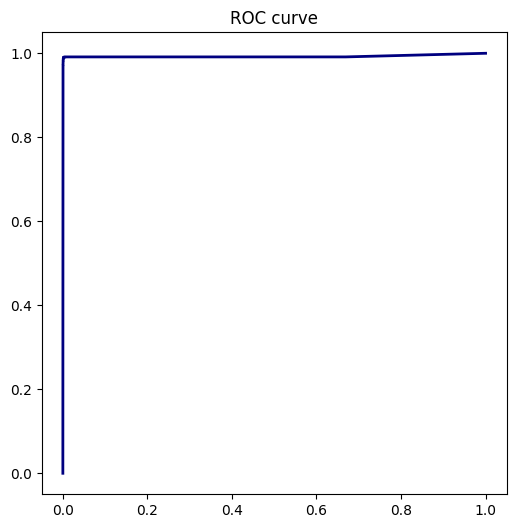

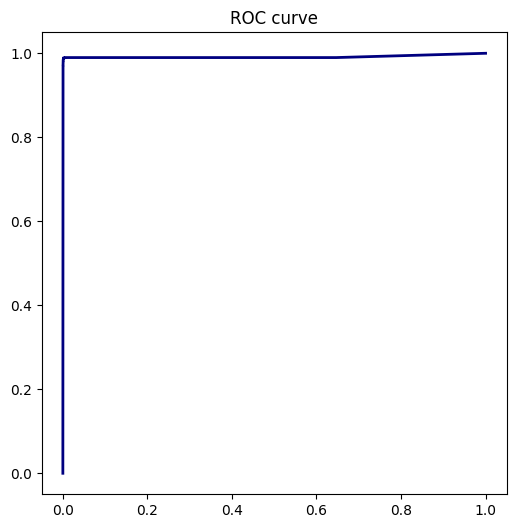

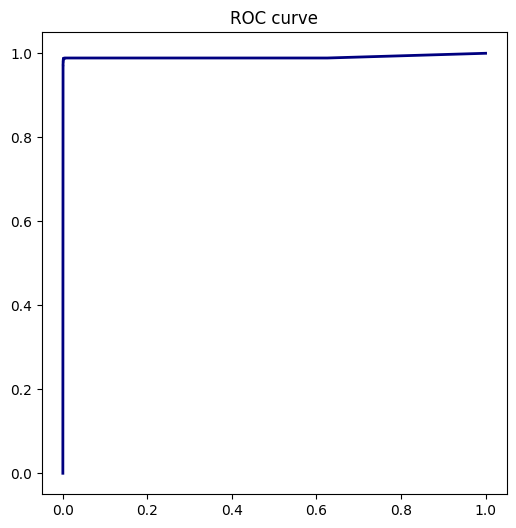

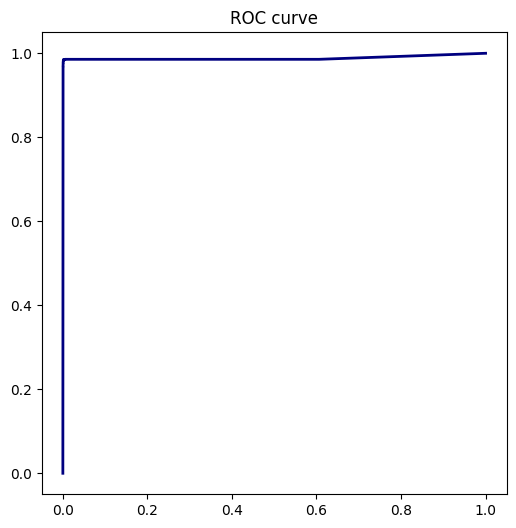

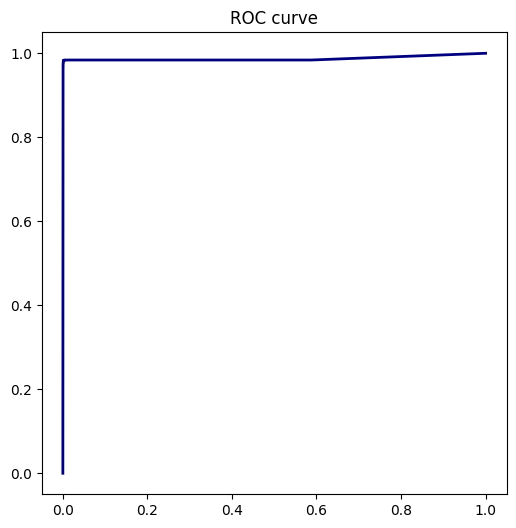

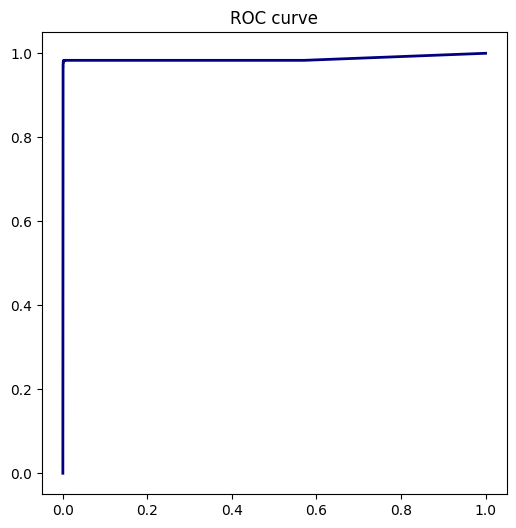

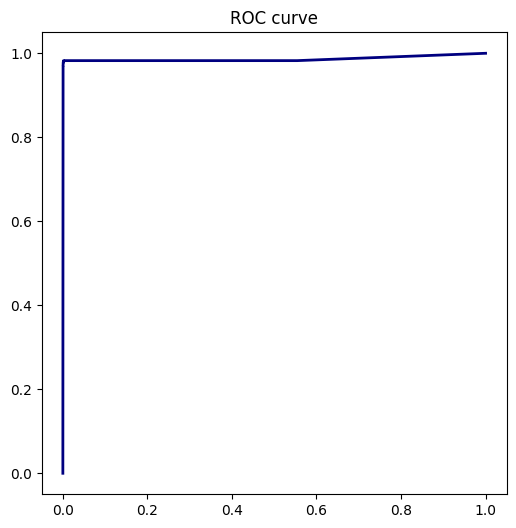

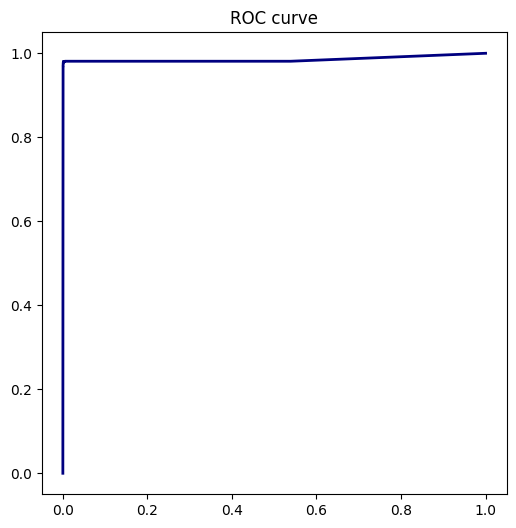

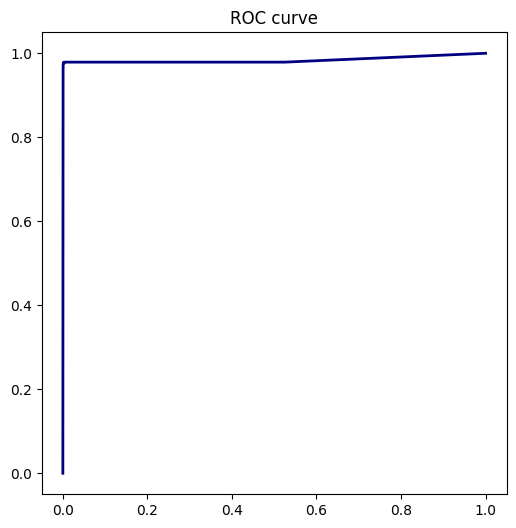

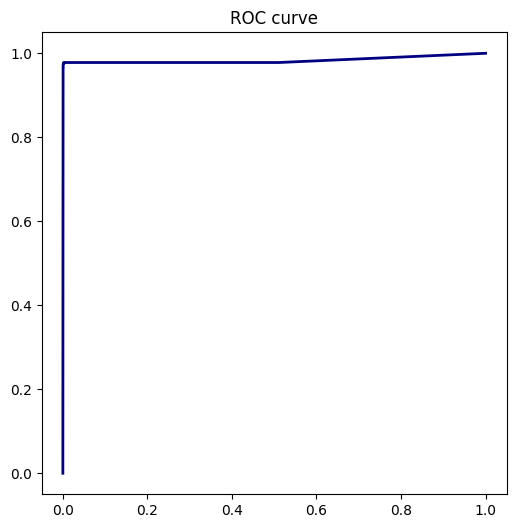

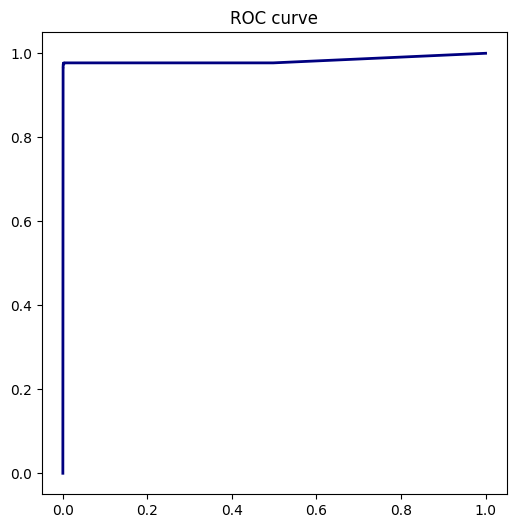

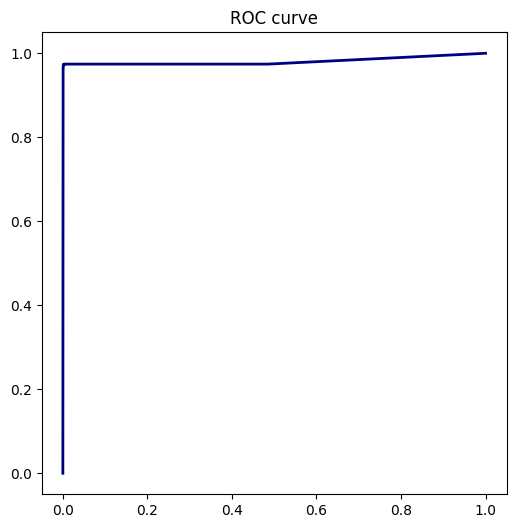

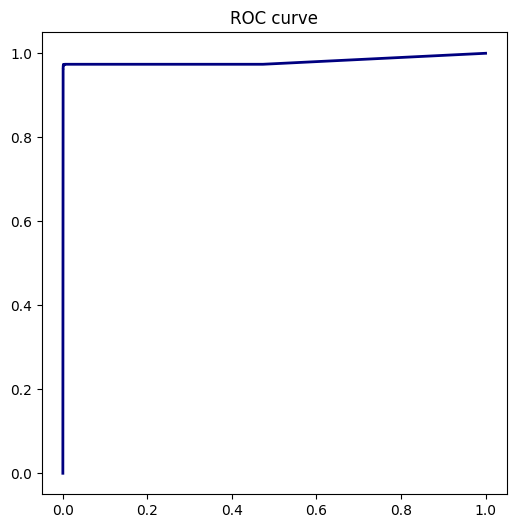

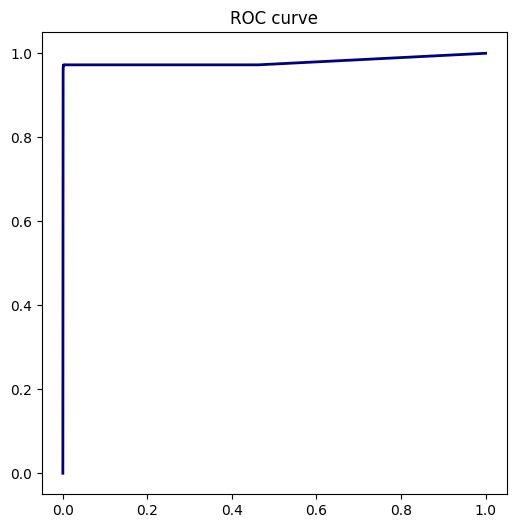

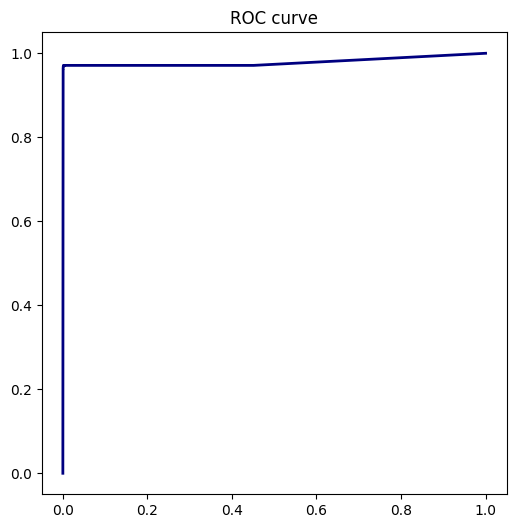

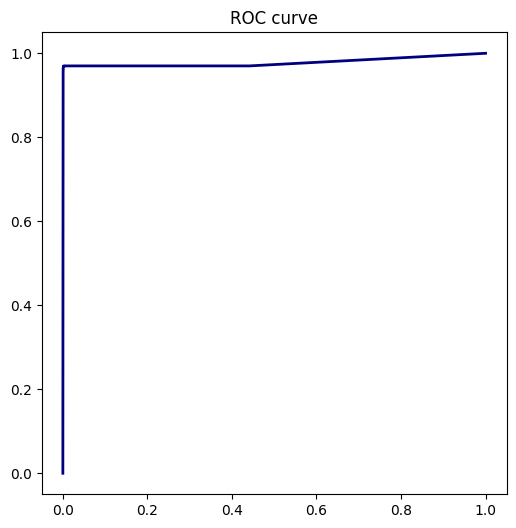

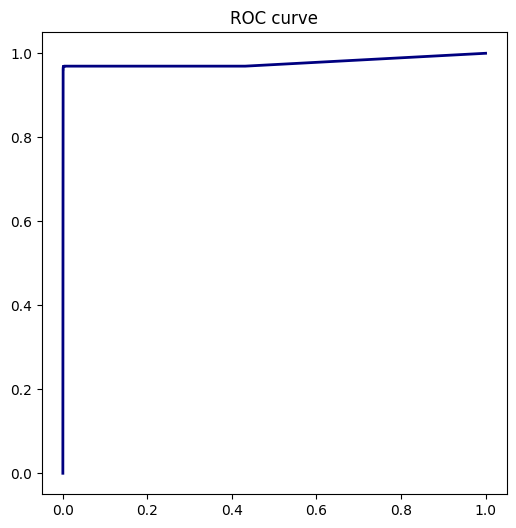

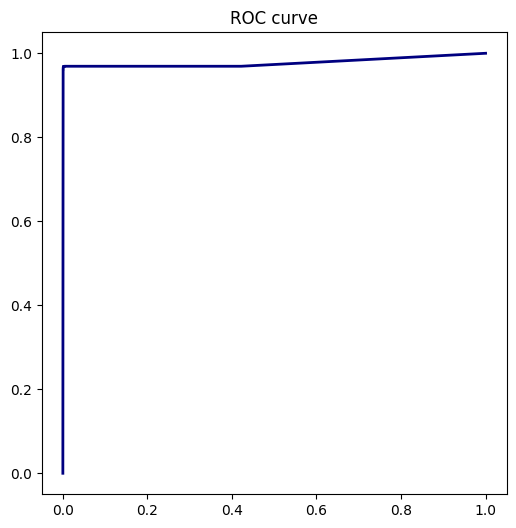

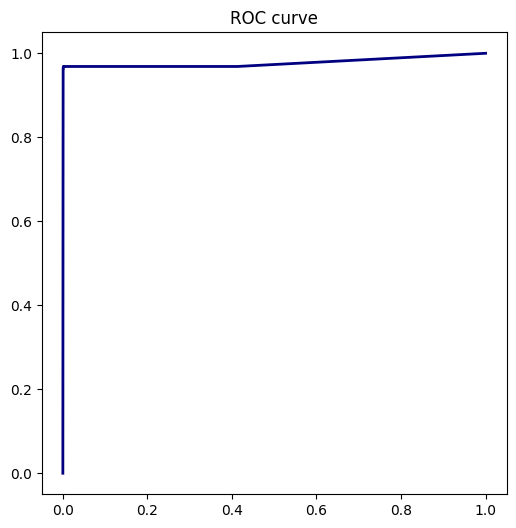

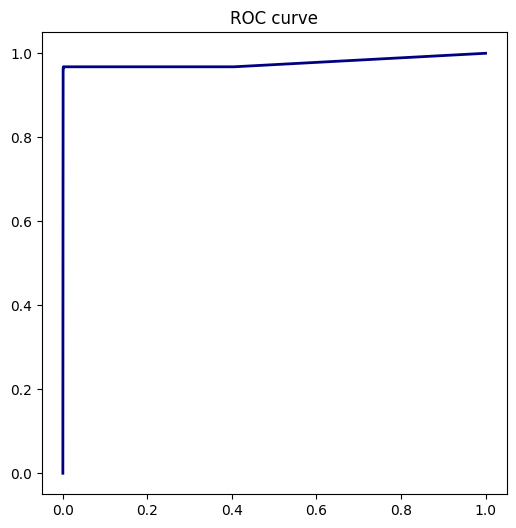

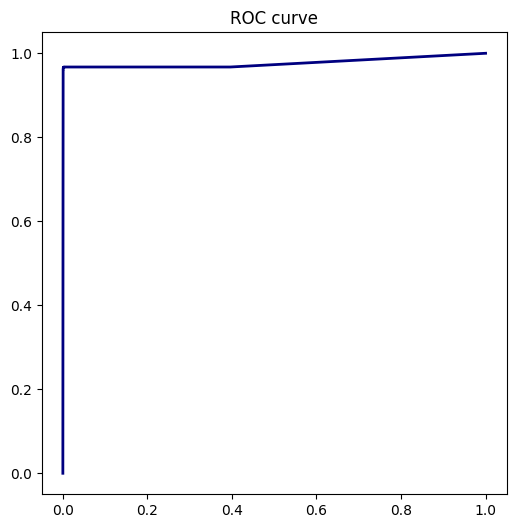

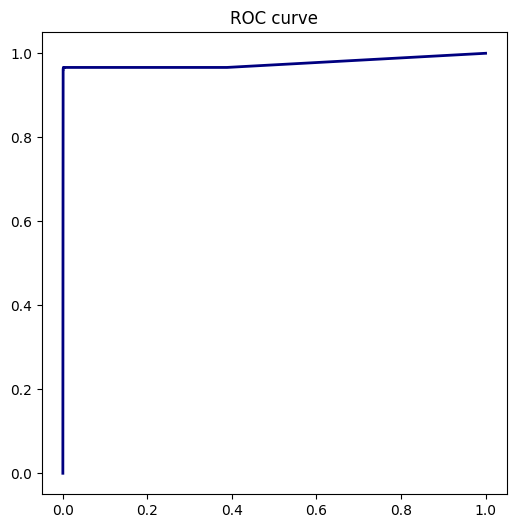

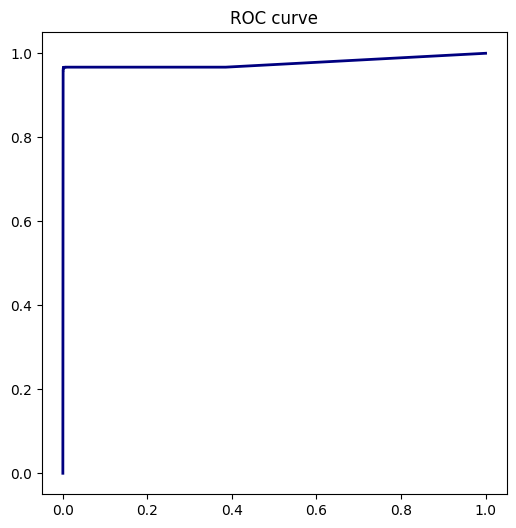

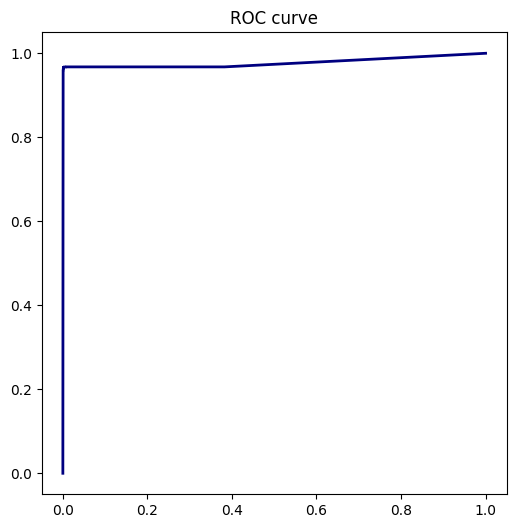

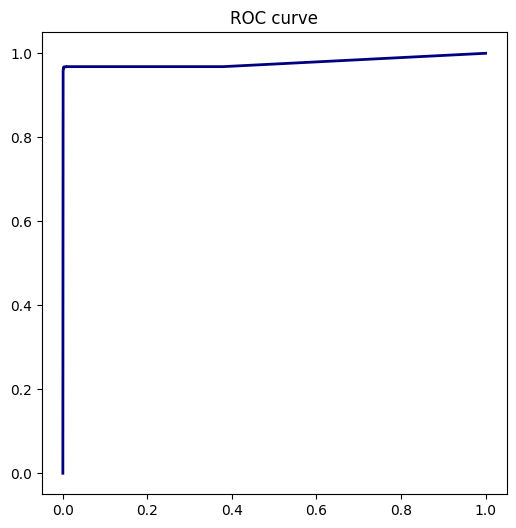

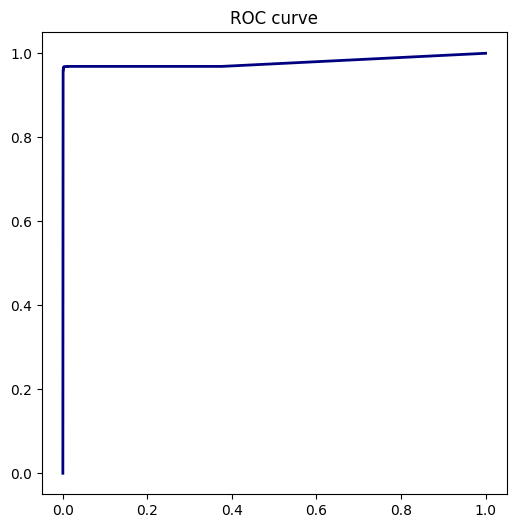

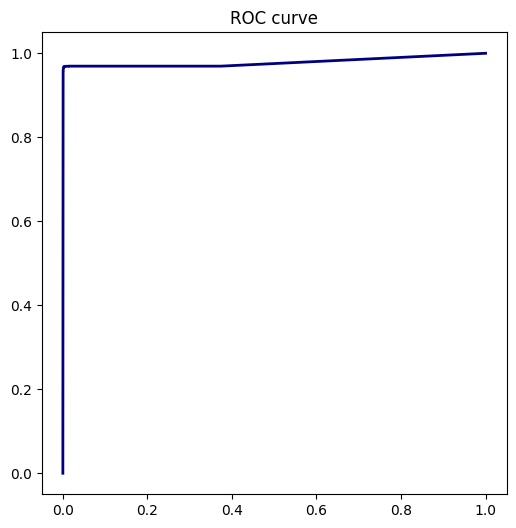

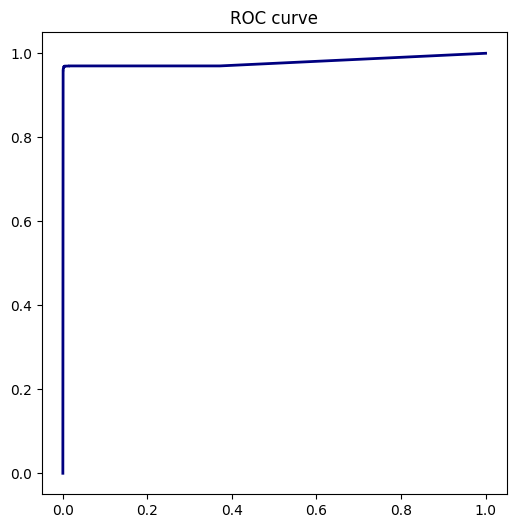

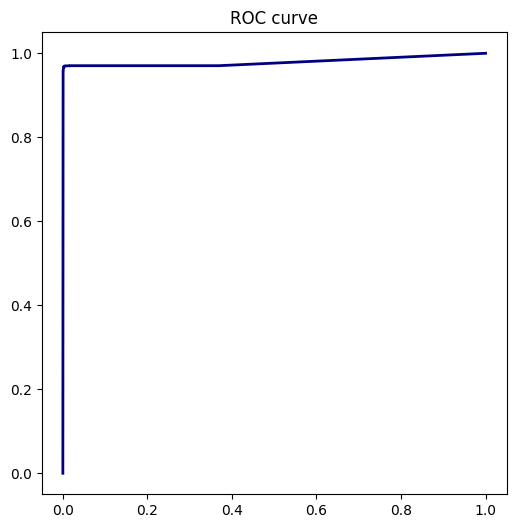

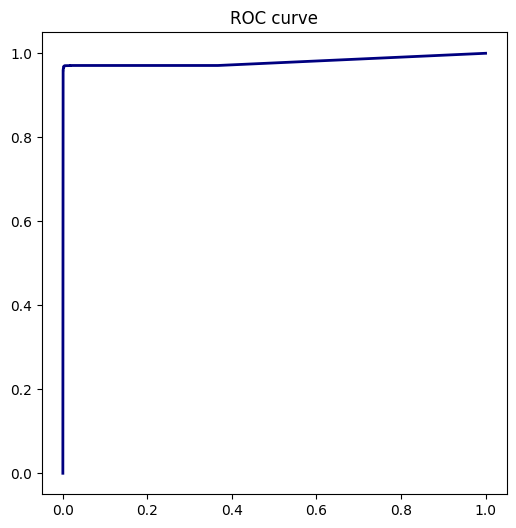

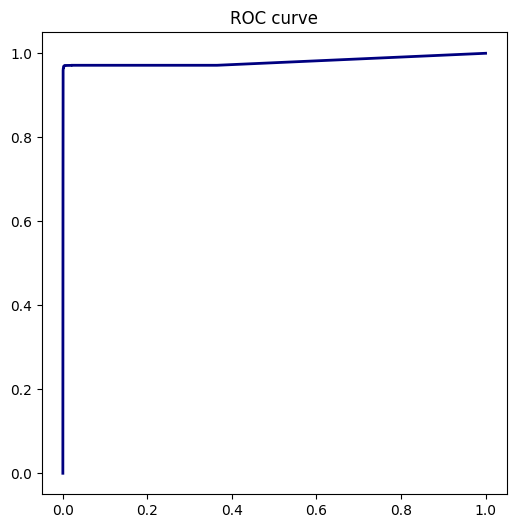

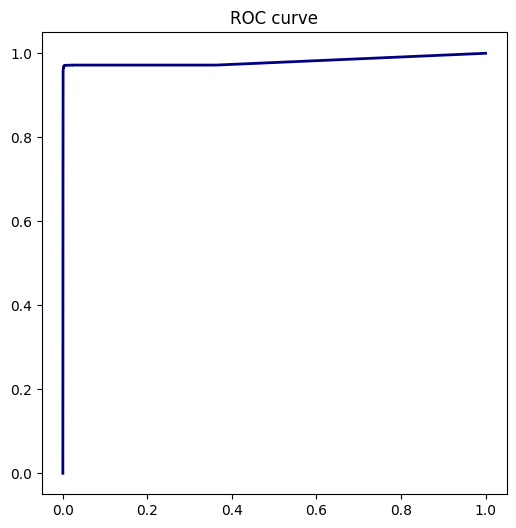

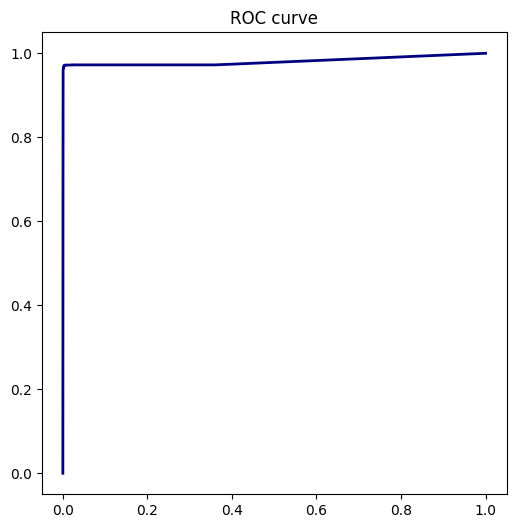

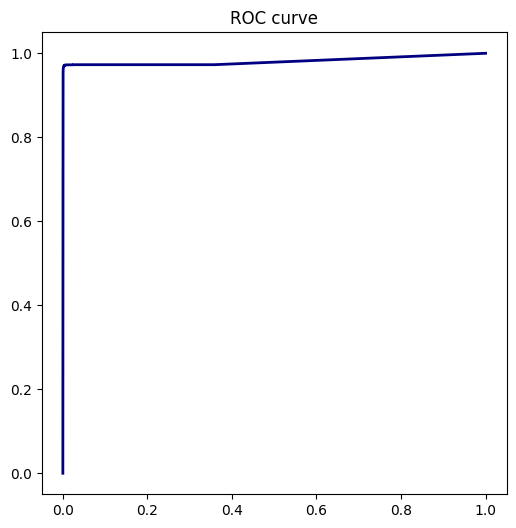

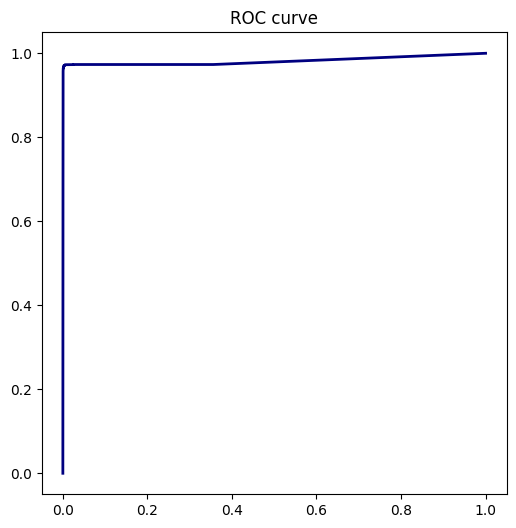

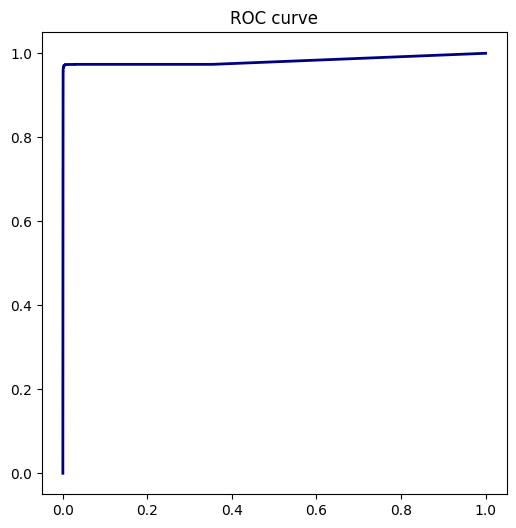

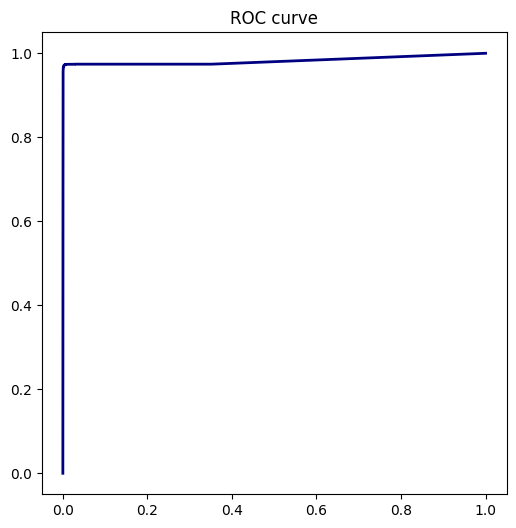

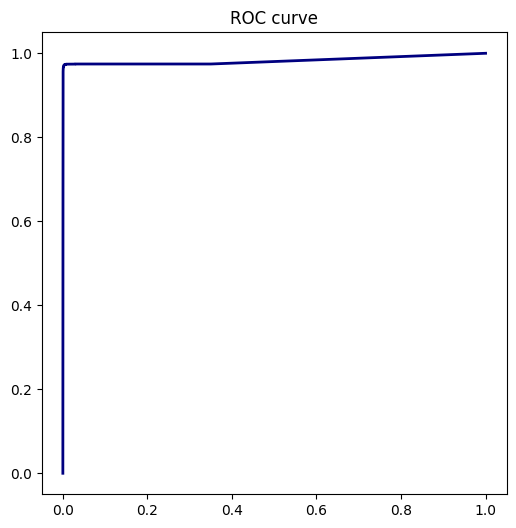

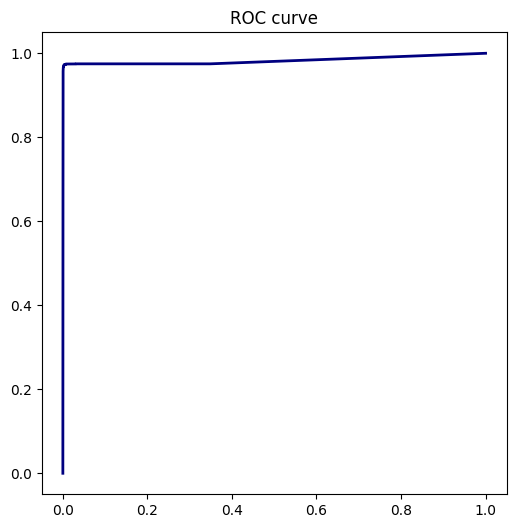

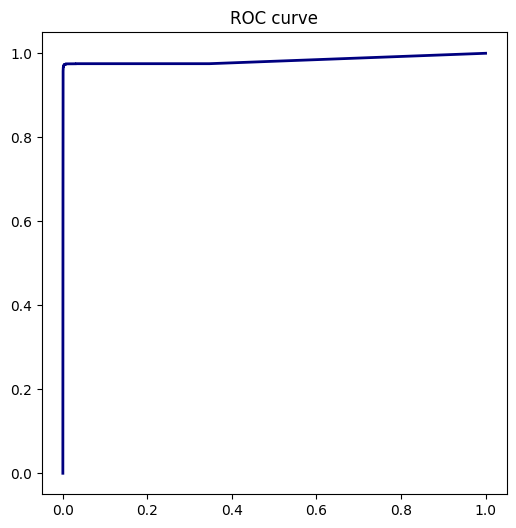

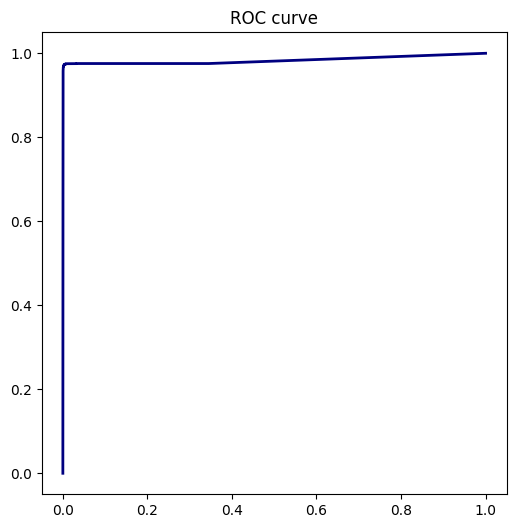

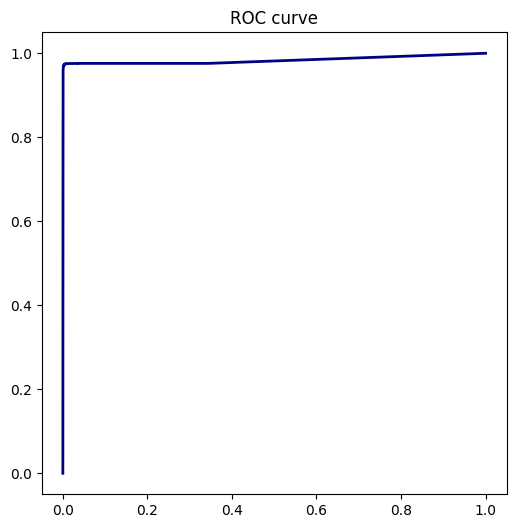

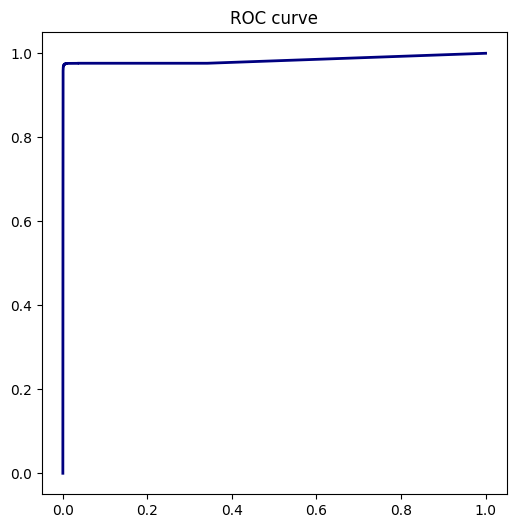

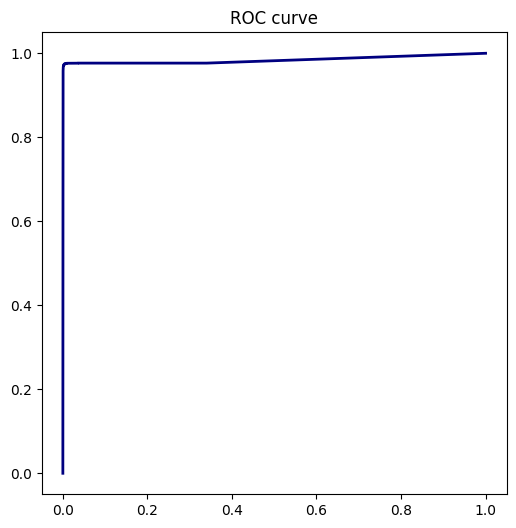

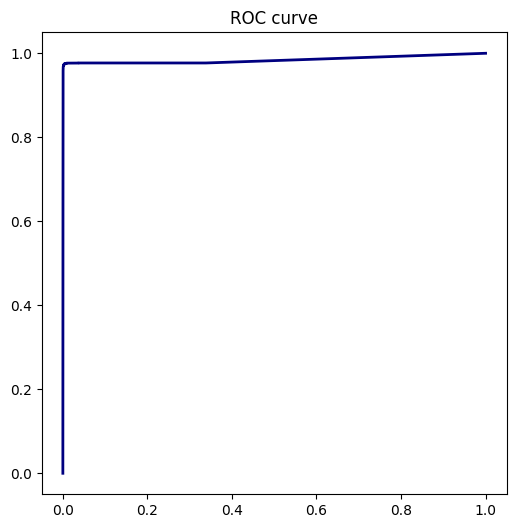

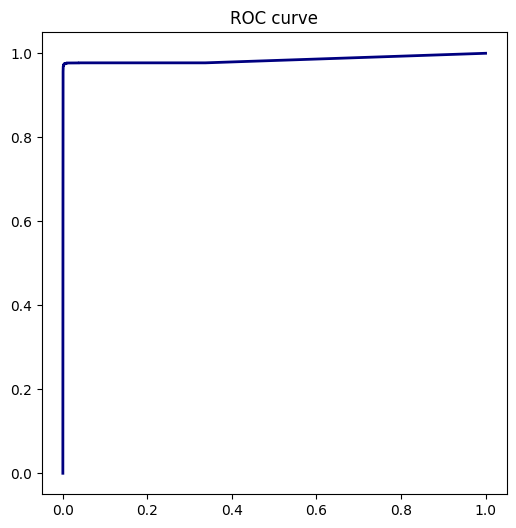

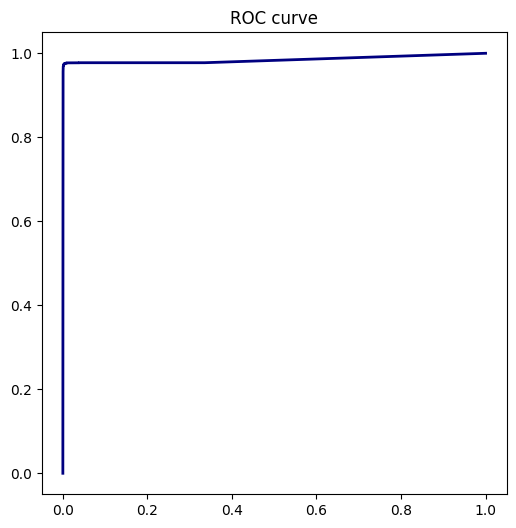

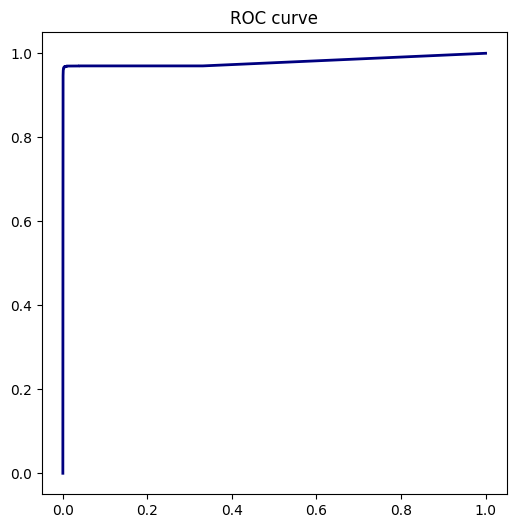

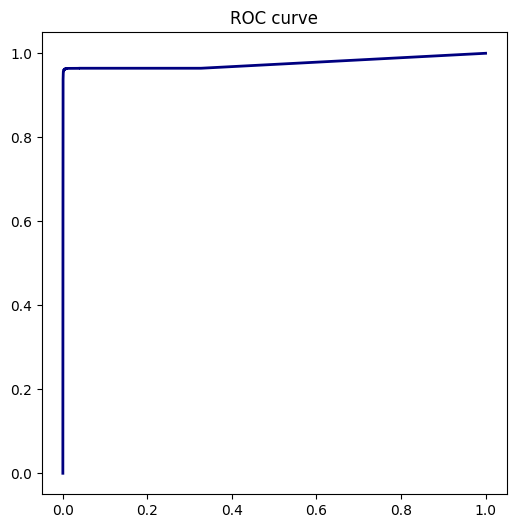

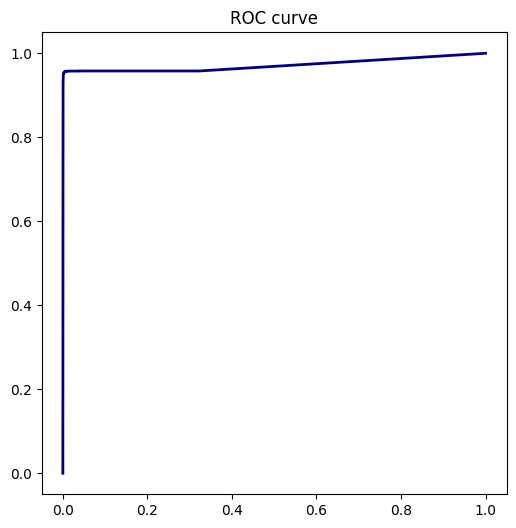

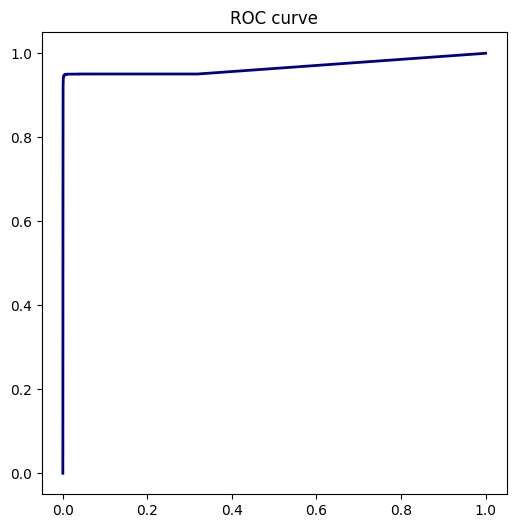

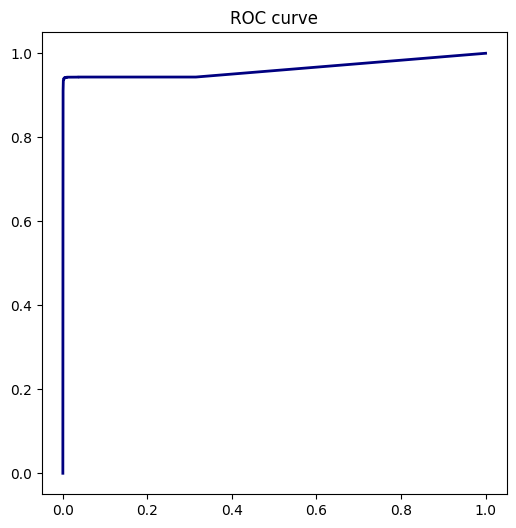

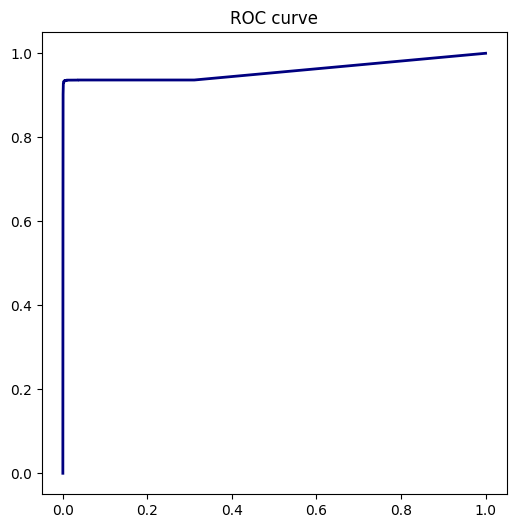

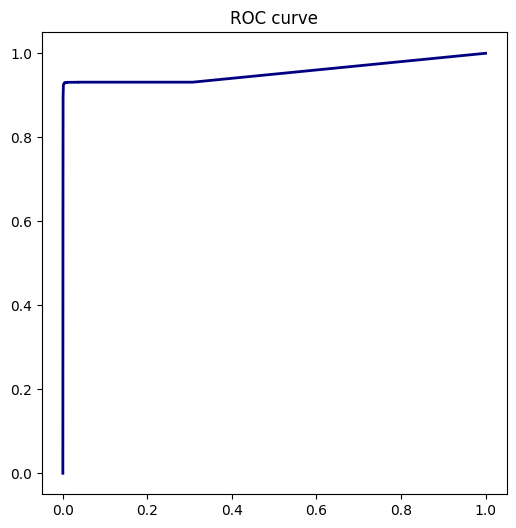

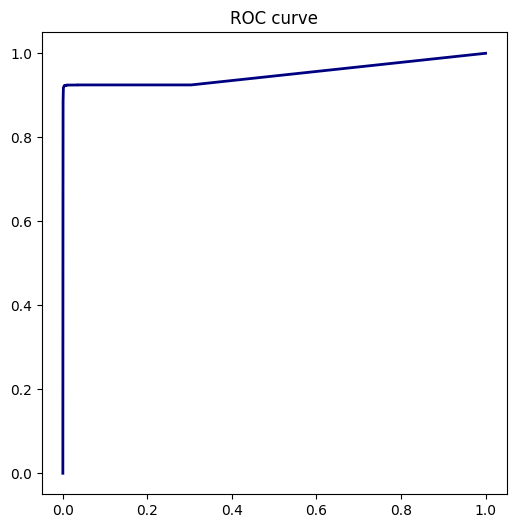

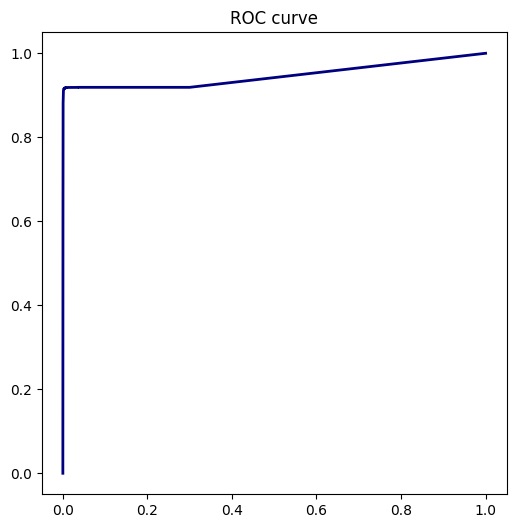

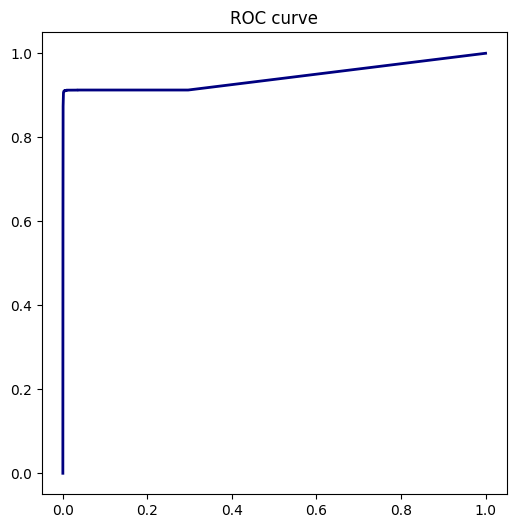

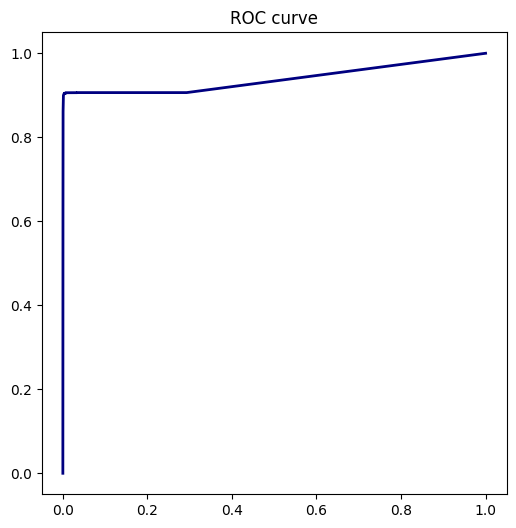

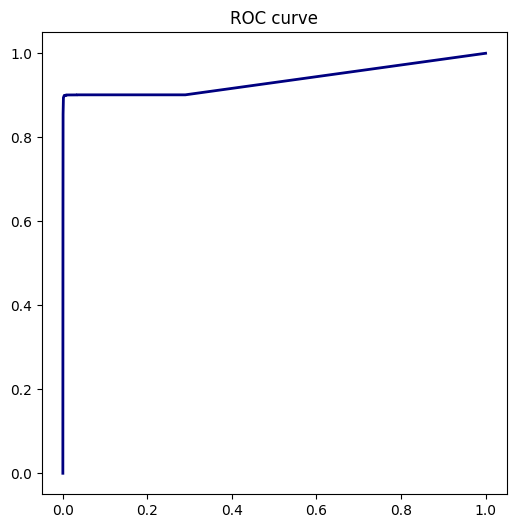

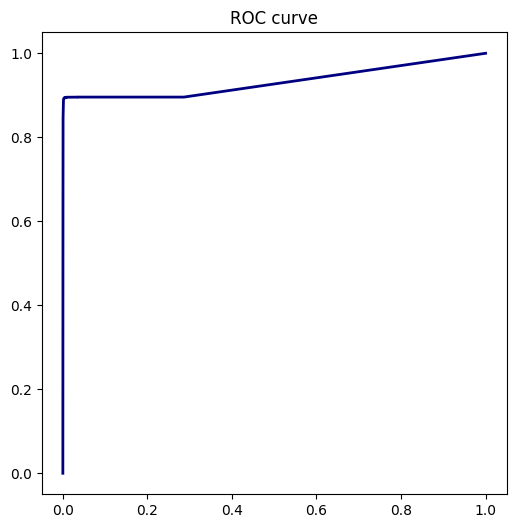

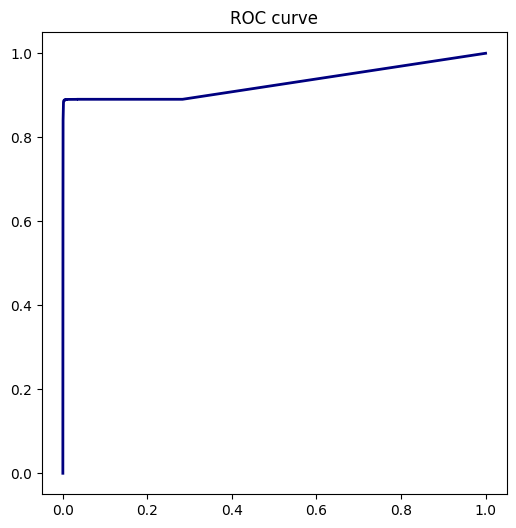

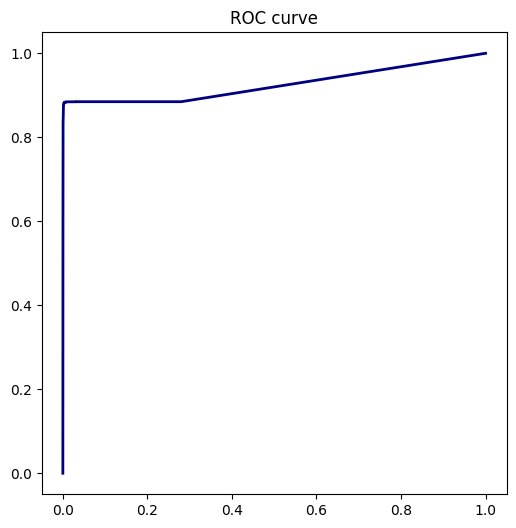

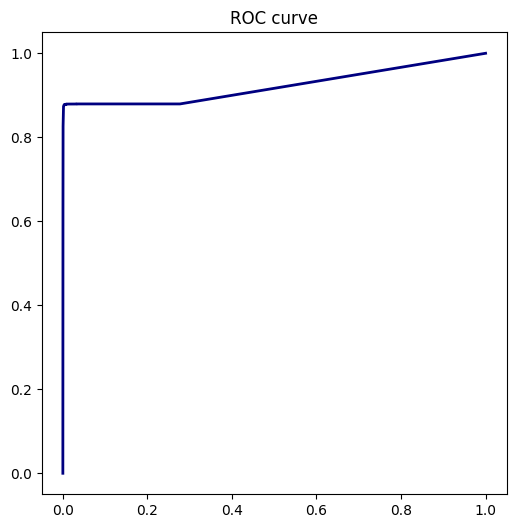

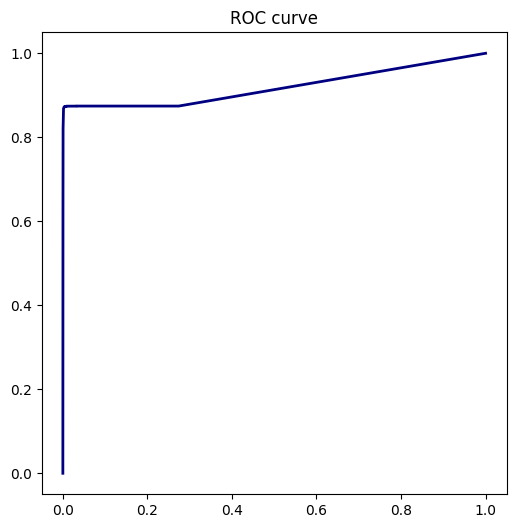

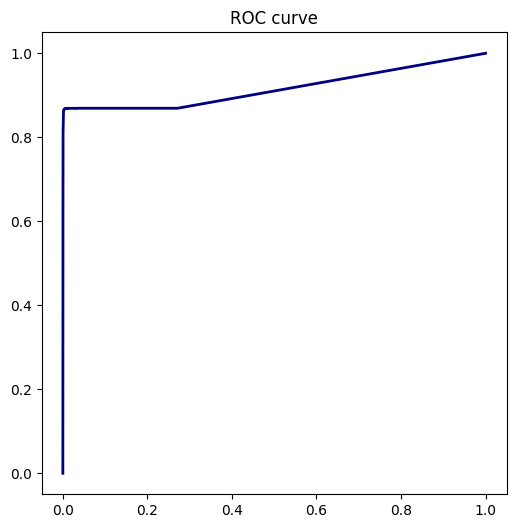

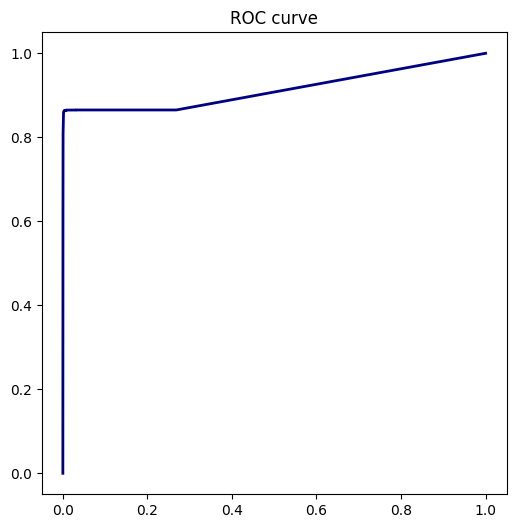

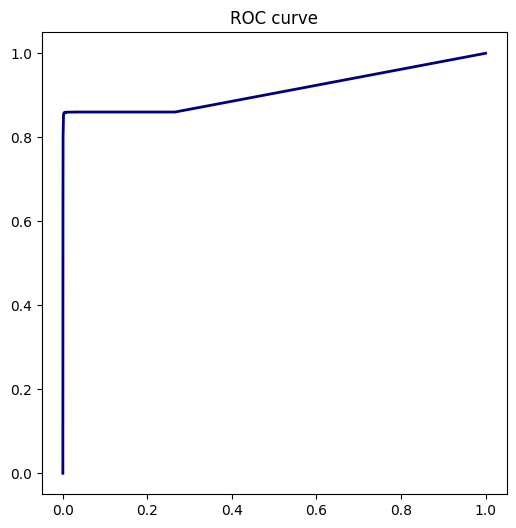

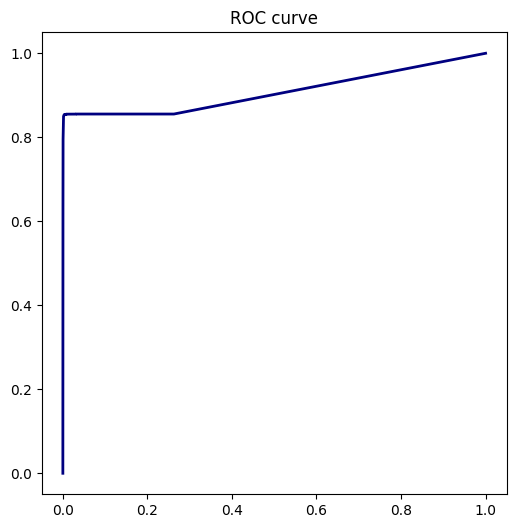

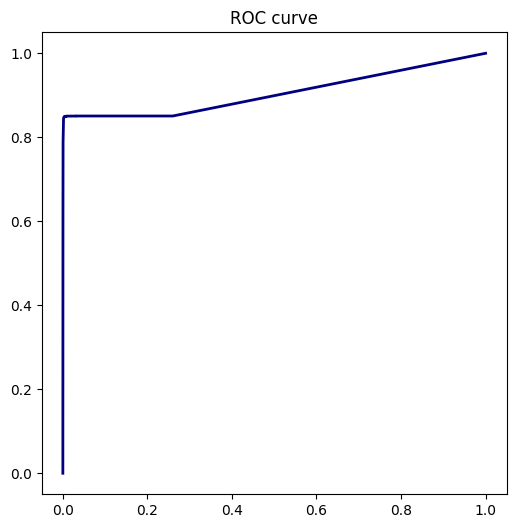

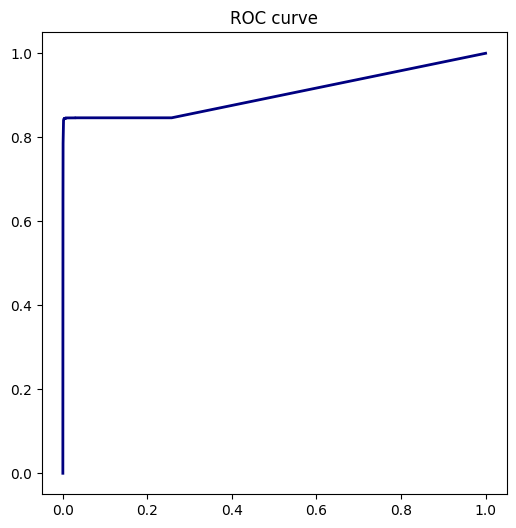

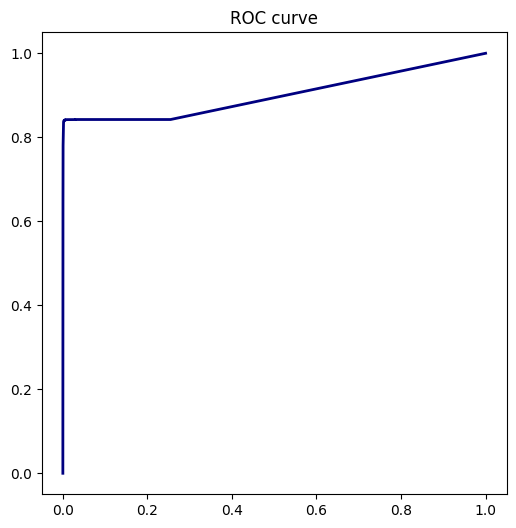

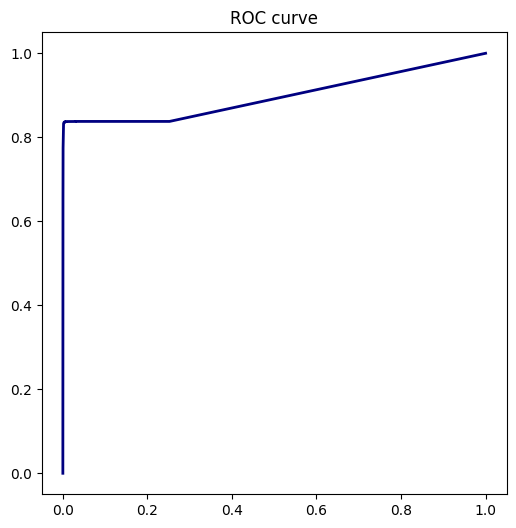

In [30]:
perform_experiments(binary_imbalanced_datasets, binary_multiclass_models, REPETITIONS, output_dir_base, TaskType.BINARY)

### Multiclass

In [ ]:
perform_experiments(multiclass_balanced_datasets, binary_multiclass_models, REPETITIONS, output_dir_base, TaskType.MULTICLASS)

In [ ]:
perform_experiments(multiclass_imbalanced_datasets, binary_multiclass_models, REPETITIONS, output_dir_base, TaskType.MULTICLASS)

### Multilabel

In [ ]:
perform_experiments(multilabel_balanced_datasets, multilabel_models, REPETITIONS, output_dir_base, TaskType.MULTILABEL)

In [ ]:
perform_experiments(multilabel_imbalanced_datasets, multilabel_models, REPETITIONS, output_dir_base, TaskType.MULTILABEL)